# TO-DO

- Plot class imbalance plot
- Neural network implementation
- Cross validation
- Third model?

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

from scipy import stats

import os
import shutil
from tqdm import tqdm

from PIL import Image

In [2]:
# Fix seed
np.random.seed(0)

## Dataset Preparation

In [3]:
current_dir = os.getcwd()
face_dir = os.path.join(current_dir, "cmu+face+images", "faces")

In [4]:
# Create dictionary based on face orientation
data_dict = {"left": [],
             "right": [],
             "straight": [],
             "up" : []}

for human in os.listdir(face_dir):
    if not human.startswith("."):
        for image in os.listdir(os.path.join(face_dir, human)):
            if (not image.endswith(".bad")) and (not image.endswith("2.pgm")) and (not image.endswith("4.pgm")):
                key = image.split("_")[1]
                data_dict[key].append(os.path.join(face_dir, human, image))

In [5]:
# Create folders with respective labels
orient_folder = "face_orientation"

location = os.path.join(current_dir, "cmu+face+images")
if not os.path.exists(os.path.join(location, orient_folder)):
    os.mkdir(os.path.join(location, orient_folder))
face_orientation =  os.path.join(location, orient_folder)

for key in data_dict.keys():
    if not os.path.exists(os.path.join(face_orientation, key)):
        os.mkdir(os.path.join(face_orientation, key))
    path = os.path.join(face_orientation, key)
    for image in data_dict[key]:
        shutil.copy(image, os.path.join(path, os.path.split(image)[-1]))

## Dataset Analysis

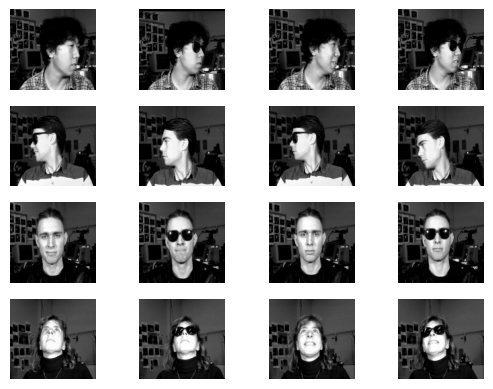

In [6]:
# Check example images
current_dir = os.getcwd()
orient_folder = "face_orientation"
location = os.path.join(current_dir, "cmu+face+images")
face_orientation =  os.path.join(location, orient_folder)

# Gather all data
keys = ["left", "right", "straight", "up"]
all_data = [(Image.open(os.path.join(face_orientation, key, image)).convert(mode="L"), key) for key in keys for image in os.listdir(os.path.join(face_orientation, key))]

plt.figure()
for row in range(4):
    for col in range(4):
        plt.subplot2grid((4, 4), (row, col))
        example = all_data[row*200 + col][0]
        plt.imshow(example, cmap="gray")
        plt.axis("off")
plt.savefig("plots/samples.pdf", format="pdf", bbox_inches="tight")

In [7]:
all_data[0][0], all_data[0][1]

(<PIL.Image.Image image mode=L size=128x120>, 'left')

In [8]:
X = np.array([elem[0] for elem in all_data]) 
X = X.reshape((len(all_data), -1))/255.0 # (624, 120, 128) --> (624, 15360) and [0, 255] -> [0, 1]

In [9]:
shape = (120, 128)

### Principal Component Analysis

In [10]:
def PCA(data, first_k=90, shape=(120, 128), speak=True):

    center = data.mean(axis= 0)
    centered = data - center # Subtract mean 

    u, s, vt = np.linalg.svd(centered)
    
    lambdas = np.square(s)/(X.shape[0] - 1)

    first_k = 90
    eig_first_k = lambdas[0:first_k]/sum(lambdas)
    preserved = [sum(eig_first_k[0:i+1]) for i in range(first_k)]
    eig_idx = first_k - np.sum(np.array(preserved) >= 0.9)

    if speak:
        plt.figure()
        plt.imshow(center.reshape(shape))
        plt.axis("off")
        #plt.title("Mean of the data matrix")
        plt.savefig("plots/pca_mean.pdf", format="pdf", bbox_inches="tight")


        plt.figure()
        plt.imshow(centered[0].reshape(shape))
        plt.axis("off")
        #plt.title("Centered image example")


        # Plot the explained variance ratio
        plt.figure()
        plt.bar(np.linspace(1,first_k,first_k), eig_first_k, label="Variance", color="black")
        plt.xticks(np.linspace(1,first_k,first_k), [x + 1 for x in range(first_k)])
        plt.xticks(np.linspace(0, first_k, 10), [str(num) for num in np.linspace(0, first_k, 10, dtype=int)])
        plt.yticks(np.arange(0.0, 1.0, 0.1), [str(num)[:3] for num in np.arange(0.0, 1.0, 0.1)])
        plt.xlabel("kth largest principal component")
        plt.ylabel("Proportion of variance captured")
        #plt.title(f"Proportion of variance captured by the first ten largest principal components \n eig_idx = {eig_idx}")
        plt.plot(np.linspace(1,first_k,first_k), preserved, label="Cumulative Variance", color="blue")
        plt.axhline(y=0.9, color="red", label="90% Variance")
        plt.legend()
        plt.grid()
        plt.savefig("plots/proportion_of_variance.pdf", format="pdf", bbox_inches="tight")

        # Plot first 16 principal components
        plt.figure()
        plotdim = 4
        #plt.title(f"First {plotdim**2} principal components")
        for row in range(plotdim):
            for col in range(plotdim):
                plt.subplot2grid((plotdim, plotdim), (row, col))
                plt.imshow(X=vt[plotdim*row + col].reshape(shape))
                plt.axis("off")
        
        plt.savefig("plots/pca_first_k.pdf", format="pdf", bbox_inches="tight")

    return center, lambdas, vt, eig_idx

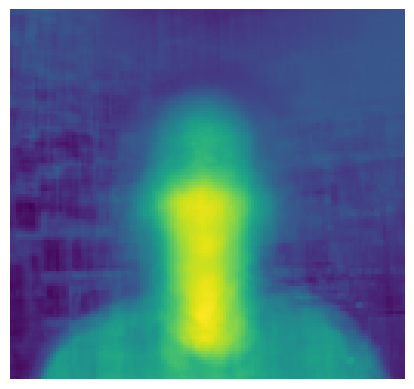

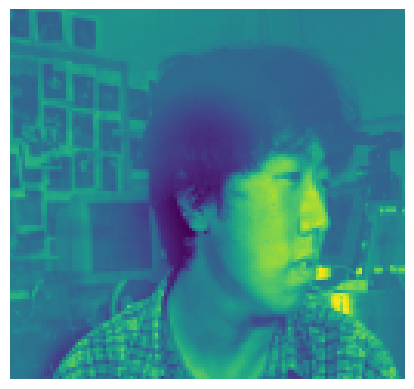

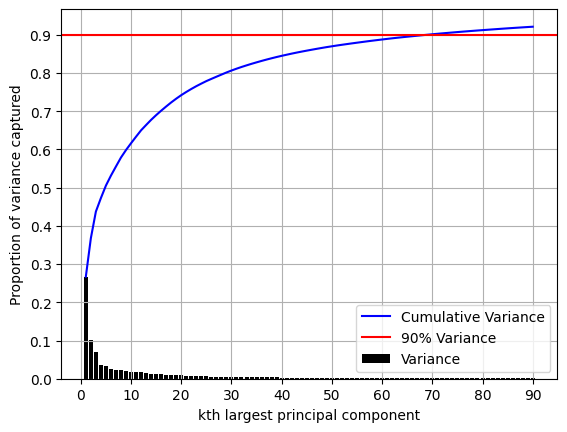

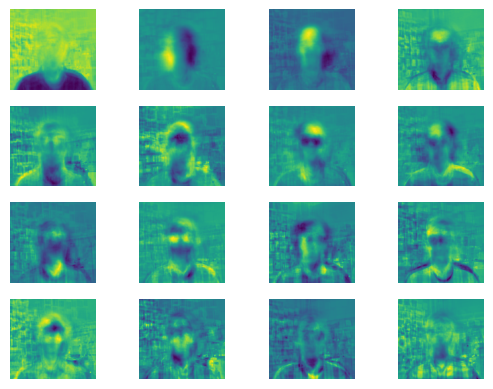

In [11]:
center, lambdas, vt, eig_idx = PCA(X)

In [12]:
# Compute coefficients and reconstruct image
coeffs = X[0].reshape((1, -1)) @ vt[:eig_idx].T
recon = coeffs @ vt[:eig_idx]

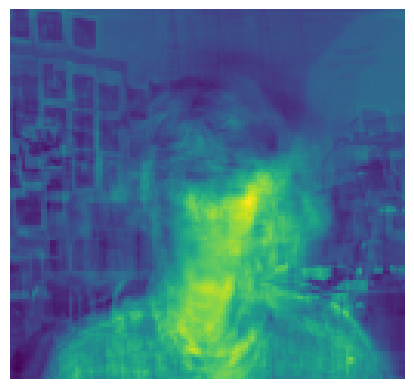

In [13]:
plt.imshow(X[0].reshape(shape))
plt.axis("off")
#plt.title("First image")
plt.savefig("plots/first_img.pdf", format="pdf", bbox_inches="tight")

plt.imshow((recon + center).reshape(shape))
plt.axis("off")
#plt.title(f"First image reconstructed with first {eig_idx} components")
plt.savefig("plots/first_img_reconstruction.pdf", format="pdf", bbox_inches="tight")

### Non-negative Matrix Factorization

In [14]:
def NNMF(data, shape=(120, 128), embedding_size=64, iterations=1000):

    nnmf_scaler = np.sqrt(np.mean(data)/data.shape[0])
    nnmf_loss = []

    # Initialize non-negative matrices
    W = abs(np.random.standard_normal((X.shape[0], embedding_size)))*nnmf_scaler
    H = abs(np.random.standard_normal((embedding_size, X.shape[-1])))*nnmf_scaler

    for iteration in tqdm(range(iterations)):
        W_numerator = np.matmul(X, H.T)
        W_denominator = np.matmul(np.matmul(W, H), H.T)
        W_alpha = np.divide(W_numerator, W_denominator)
        
        W = W*W_alpha
        
        H_numerator = np.matmul(W.T, X)
        H_denominator = np.matmul(np.matmul(W.T, W), H)
        H_alpha = np.divide(H_numerator, H_denominator)
        
        H = H*H_alpha
        
        nnmf_loss.append(np.linalg.norm(X - np.matmul(W, H), "fro"))
    
    return W, H, nnmf_loss

In [15]:
W, H, nnmf_loss = NNMF(X)

100%|██████████| 1000/1000 [02:56<00:00,  5.67it/s]


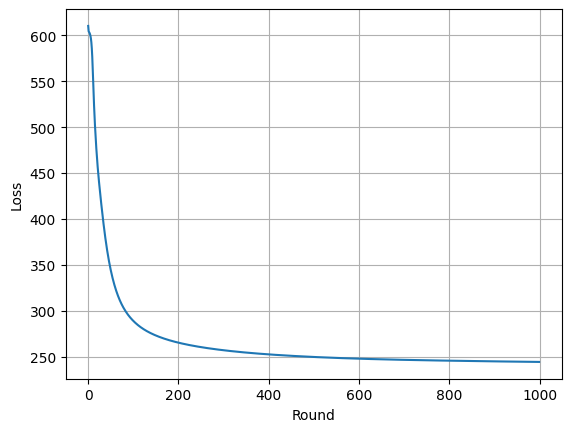

In [16]:
plt.figure()
plt.grid()
plt.plot(nnmf_loss)
plt.xlabel("Round")
plt.ylabel("Loss")
plt.savefig("plots/nmf_loss.pdf", format="pdf", bbox_inches="tight")

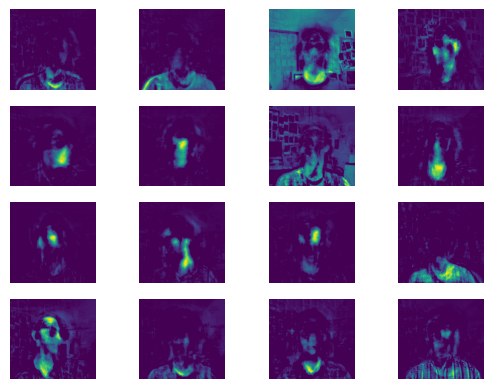

In [17]:
#Plot NMF-faces
plt.figure()
plot_dim = 4
for i in range(plot_dim):
    for j in range(plot_dim):
        plt.subplot(plot_dim, plot_dim, plot_dim*i + j + 1)
        plt.imshow(H[plot_dim*i + j,:].reshape(shape))
        plt.axis("off")
plt.savefig("plots/nmf_features.pdf", format="pdf", bbox_inches="tight")

In [18]:
# Obtain mixing coefficients for the first 6 people, NMF
coeff_six_images_nmf = W[0,:].reshape(1, -1)

In [19]:
# Reconstruct the first 6 images, NMF
recon_six_images_nmf = np.matmul(coeff_six_images_nmf, H)

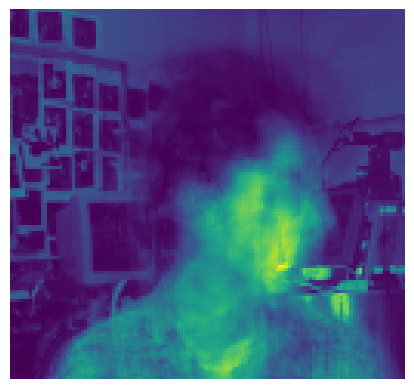

In [20]:
# Plot the first 6 reconstructed faces, NMF
plt.figure()
plt.imshow(recon_six_images_nmf.reshape(shape))
plt.axis("off")
plt.savefig("plots/first_img_nmf_recon.pdf", format="pdf", bbox_inches="tight")

### JL Transform (Random Projections)

In [21]:
jl_error = 0.5
jl_bound = 24*np.log(X.shape[-1])/(3*jl_error**2 - 2*jl_error**3)
print(f"Minimum dimension for random projection {jl_bound}")

Minimum dimension for random projection 462.69705632167984


In [22]:
random_proj_matrix = np.random.multivariate_normal(np.zeros(int(jl_bound)), np.eye(int(jl_bound))/jl_bound**2)

In [23]:
random_proj_matrix = np.random.normal(loc=0, scale=1/jl_bound, size=(X.shape[-1], int(jl_bound)))

In [24]:
random_proj_matrix.shape

(15360, 462)

In [25]:
random_proj_coeffs = X[0].reshape((1, -1)) @ random_proj_matrix
random_proj_recon = random_proj_coeffs @ random_proj_matrix.T

## Classification

In [26]:
def sample_no_replacement(arr, num):
    np.random.shuffle(arr)
    x, arr = arr[:num], arr[num:]
    return x, arr

In [27]:
def create_train_test(data, labels, train_split=80):
    assert(0 <= train_split <= 100)

    train_data, train_labels = [], []
    test_data, test_labels = [], []
    targets = np.array([m[-1] for m in data])
    for label in labels.keys():
        points = np.array([data[i][0] for i in (targets == label).nonzero()[0]])
        train, test = sample_no_replacement(points, len(points)*train_split//100)
        train_data.append(train)
        test_data.append(test)
        for i in range(len(train)):
            train_labels.append(label)
        for i in range(len(test)):
            test_labels.append(label)
    
    train_data = np.concatenate(train_data)
    train_data = train_data.reshape(train_data.shape[0], -1)/255.0
    train_labels = np.array([labels[elem] for elem in train_labels])
    test_data = np.concatenate(test_data)
    test_data = test_data.reshape(test_data.shape[0], -1)/255.0
    test_labels = np.array([labels[elem] for elem in test_labels])

    return train_data, train_labels, test_data, test_labels

In [28]:
labels = {"left": 0, "right": 1, "straight" : 2, "up": 3}

In [29]:
train_data, train_labels, test_data, test_labels = create_train_test(all_data, labels)

### KNN

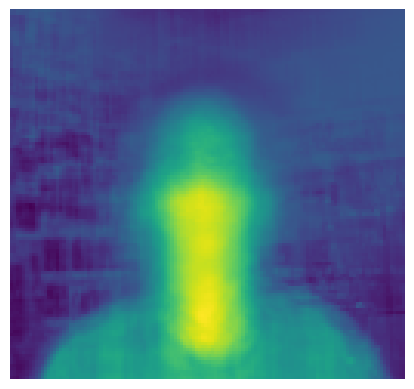

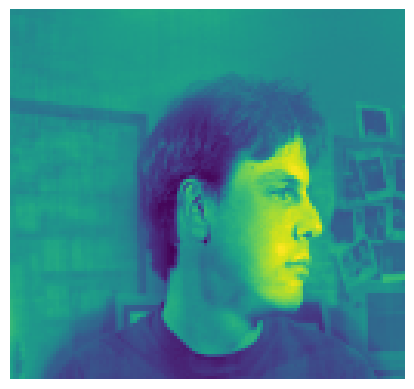

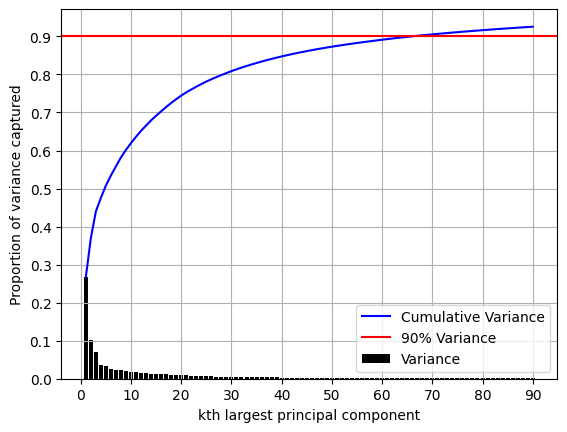

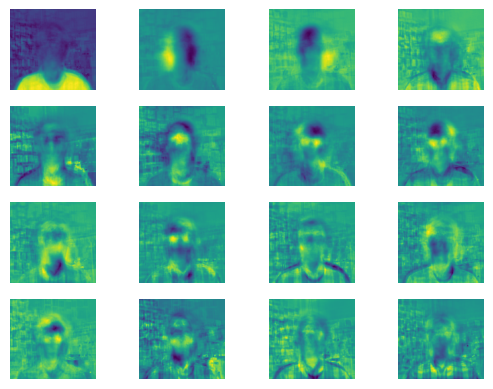

In [30]:
_, _, vt, eig_idx = PCA(train_data, speak=True)

In [31]:
# Prepare train and test embeddings through PCA
train_embeddings = train_data.reshape((train_data.shape[0], -1)) @ vt[:eig_idx].T
test_embeddings = test_data.reshape((test_data.shape[0], -1)) @ vt[:eig_idx].T

In [32]:
test_embeddings.shape

(127, 65)

In [33]:
def KNN(train_embeddings, train_labels, test_embeddings, test_labels, k=3, speak=True):

    assert(k > 0)

    knn_confusion_matrix = np.zeros(shape=[len(labels)]*2)

    for data, label in zip(test_embeddings, test_labels):

        distances = np.linalg.norm(train_embeddings - data, axis=1)
        neighbors = np.sort(distances)[:k]
        preds = []

        for neighbor in neighbors:
            pred_idx = np.where(distances == neighbor)
            preds.append(train_labels[pred_idx][0])
        prediction = stats.mode(preds).mode
        
        knn_confusion_matrix[label, prediction] += 1

    knn_accuracy = knn_confusion_matrix.trace()/knn_confusion_matrix.sum()

    if speak:
        print(f"{k}-KNN accuracy: {knn_accuracy}")

        plt.figure()
        sns.heatmap(knn_confusion_matrix, annot=True, cbar=False, xticklabels=labels.keys(), yticklabels=labels.keys(), cmap="YlGnBu")
        plt.xlabel("Predicted")
        plt.ylabel("Ground truth")
        #plt.title(f"{k}-KNN confusion matrix")
        plt.savefig(f"plots/knn_confusion_{k}.pdf", format="pdf", bbox_inches="tight")
    
    return knn_accuracy, knn_confusion_matrix

C:\Users\User\AppData\Local\Temp\ipykernel_18188\3760152568.py:16: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  prediction = stats.mode(preds).mode


16-KNN accuracy: 0.6614173228346457


(0.6614173228346457,
 array([[22.,  0.,  6.,  4.],
        [ 0., 28.,  0.,  3.],
        [ 0.,  0., 19., 13.],
        [ 3.,  0., 14., 15.]]))

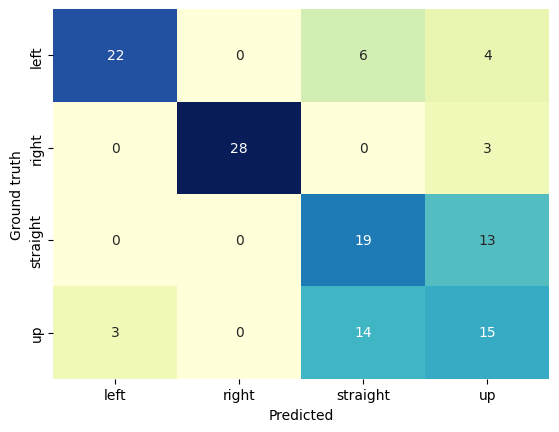

In [34]:
k = 16
KNN(train_embeddings, train_labels, test_embeddings, test_labels, k)